# Clasificación de los datos 
#### JJD-Predictors

Se lee del archivo "./refs_classified.pkl" las categorias asignadas para distintas referencias. 

In [1]:
import pandas as pd
import numpy as np
df_result = pd.read_pickle("./refs_classified.pkl")
df_result.loc[df_result["clasificacion"] == "Hogar"].ref.unique()

array(['acueducto', 'serviciudad esp', 'gases caribe sa esp',
       'emserchia esp', 'hydros mosquera esp',
       'aguas sabana sa esp sincelejo', 'proactiva aguas monteria',
       'emcartago', 'empresas publicas medellin esp', 'arrendamientos',
       'pago electronico emcaliach', 'pago factura gas natural cupon'], dtype=object)

Para hacer la clasificación se eliminan aquellas palabras que son comunes en la mayoría de referencias, que solo agregan ruido al clasificador y al conjunto de datos por clasificar. 

In [2]:
data_transactions = pd.read_pickle("./transactions_BC.pkl")
data_transactions['ref'] = data_transactions.ref.astype('str') 
data_transactions['ref'] = data_transactions.ref.replace(':',' ', regex = True)
data_transactions['ref'] = data_transactions.ref.replace('pago ','', regex = True)
data_transactions['ref'] = data_transactions.ref.replace('factura','',regex = True)
data_transactions['ref'] = data_transactions.ref.replace('pagos ','',regex = True)
data_transactions['ref'] = data_transactions.ref.replace('facturas','',regex = True)
data_transactions['ref'] = data_transactions.ref.replace('compra','',regex = True)
data_transactions['ref'] = data_transactions.ref.replace('compras','',regex = True)
data_transactions["ref"] = data_transactions["ref"].apply(lambda x: x.strip()) 
data_transactions["ref"] = data_transactions["ref"].replace({"nan":np.nan, '':np.nan, '//':np.nan})
data_transactions = data_transactions[(~data_transactions["ref"].isnull())]
data_transactions.count()

id_trn_ach      8187193
id_cliente      8187193
fecha           8187193
hora            8187193
valor_trx       8187193
sector          2913027
subsector       2913027
descripcion     2913027
descripcion2      16138
ref             8187193
dtype: int64

In [3]:
df_result['ref'] = df_result.ref.astype('str') 
df_result['ref'] = df_result.ref.replace(':',' ', regex = True)
df_result['ref'] = df_result.ref.replace('pago ','',regex = True)
df_result['ref'] = df_result.ref.replace('factura','',regex = True)
df_result['ref'] = df_result.ref.replace('pagos ','',regex = True)
df_result['ref'] = df_result.ref.replace('facturas','',regex = True)
df_result['ref'] = df_result.ref.replace('compra','',regex = True)
df_result['ref'] = df_result.ref.replace('compras','',regex = True)
df_result["ref"] = df_result["ref"].apply(lambda x: x.strip()) 
df_result["ref"] = df_result["ref"].replace({"nan":np.nan, '':np.nan, '//':np.nan})
df_result = df_result[(~df_result["ref"].isnull())]

Se agregan ciertos valores faltantes y relevantes para el clasificador que se encontraron en el campo de ref muchas veces.

In [4]:
df2 = pd.DataFrame([["conjunto residencial", "Hogar"], ["conj resi", "Hogar"],["cartera", "Salud"],
                   ["administracion edificio", "Hogar"], ["admon edif", "Hogar"]], columns=["ref", "clasificacion" ])
df_result = df_result.append(df2, ignore_index=True)
df_result.clasificacion.value_counts()

Gobierno           126
Entretenimiento    112
Subscripcion        52
Educacion           46
TyC                 26
Transporte          26
Pago de Deudas      25
Hogar               16
Seguros             11
Otros               10
Salud                2
Viajes               2
Comida               1
Moda                 1
Name: clasificacion, dtype: int64

Se separan las palabras con el método *word_tokenize* y luegon se estemizan las palabras para reducirlas a su raíz.

In [5]:
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')
data_transactions["ref"] = data_transactions["ref"].apply(lambda x: ' '.join([stemmer.stem(i) for i in word_tokenize(x)]))

Al hacer lo anterior ciertas referencias quedan igual por ende se eliminan. 

In [6]:
df_result["ref"] = df_result["ref"].apply(lambda x: ' '.join([stemmer.stem(i) for i in word_tokenize(x)]))
df_result = df_result.drop_duplicates()

In [7]:
df = pd.merge(data_transactions, df_result, on='ref', how='inner')
df.count()

id_trn_ach       5409566
id_cliente       5409566
fecha            5409566
hora             5409566
valor_trx        5409566
sector           2686607
subsector        2686607
descripcion      2686607
descripcion2         551
ref              5409566
clasificacion    5409566
dtype: int64

In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
%matplotlib inline

C:\Users\jcamp\Anaconda3\envs\myenv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Para entrenar correctamente el modelo de clasificación se balancea los datos correspondientes a las categorias.

In [9]:
value_counts = df_result.clasificacion.value_counts()
clasifications = value_counts.index
df_balance = pd.DataFrame(columns = ["ref", "clasificacion"])

for element in clasifications:
    df_class_0 =  df_result[df_result['clasificacion'] == element]
    df_class_0_under = df_class_0.sample(value_counts.max(), replace = True)
    df_balance = pd.concat([df_balance, df_class_0_under], axis=0)

Posteriormente, se dividen los datos en parte de entrenamiento y parte de prueba para verificar que el modelo usado para clasificar los datos tenga un buen resultado. 

In [10]:
ref_data = df_balance.ref
category_data = df_balance.clasificacion
ref_train,ref_test,Category_train,Category_test=train_test_split(ref_data,category_data,test_size=0.7,shuffle=True)

En primer lugar, se usa el método conocido como **Naive Bayes** para clasificar y se utiliza el método de cross_validation, que consiste en dividir el dataset cinco veces y computar el valor-F para cada una. Al final se muestra un arreglo con los resultados.

In [11]:
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer( )),
                     ('clf', MultinomialNB()),
 ])

scores = cross_val_score(text_clf, df_balance.ref, df_balance.clasificacion, cv=5, scoring='f1_macro')
text_clf.fit(ref_train, Category_train)
scores

array([ 0.96102989,  0.97048853,  0.99349305,  0.96060039,  0.96774115])

Adicionalmente, se verifica que tan cercano es el promedio entre datos predecidos y los reales.

In [12]:
predicted = text_clf.predict(ref_train)
print(np.mean(predicted == Category_train))
predicted = text_clf.predict(ref_test)
print(np.mean(predicted == Category_test))

0.967532467532
0.87012987013


In [13]:
print(metrics.f1_score(Category_test,predicted,average='macro'))

0.87229547072


Por otra parte, se utiliza otro método conocido como **Máquinas de soporte vectorial** para clasificar y nuevamente se usa cross_validation para verificar que tan bueno es el método.

In [14]:
text_clf_svm = Pipeline([('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('clf-svm', SGDClassifier(penalty='l2', loss='log',
alpha=1e-3, n_iter=5, random_state=42))
])

scores = cross_val_score(text_clf_svm, df_balance.ref, df_balance.clasificacion, cv=5, scoring='f1_macro')
text_clf.fit(ref_train, Category_train)
scores

C:\Users\jcamp\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


array([ 0.96430667,  0.97399221,  1.        ,  0.96703653,  0.97739123])

Adicionalmente, se verifica que tan cercano es el promedio entre datos predecidos y los reales.

In [15]:
text_clf_svm.fit(ref_train, Category_train)
predicted = text_clf_svm.predict(ref_train)
print(np.mean(predicted == Category_train))
predicted = text_clf_svm.predict(ref_test)
print(np.mean(predicted == Category_test))

1.0
0.936920222635


Se une el dataset con la información de las transacciones con el de la clasificación, comparando la columna de *ref*.

In [16]:
df = pd.merge(data_transactions, df_result , on='ref', how='outer' )

Se puede observar que 5'409569 ya son clasificados unicamente por su referencia. 

In [17]:
df.count()

id_trn_ach       8187193
id_cliente       8187193
fecha            8187193
hora             8187193
valor_trx        8187193
sector           2913027
subsector        2913027
descripcion      2913027
descripcion2       16138
ref              8187196
clasificacion    5409569
dtype: int64

Quedan entonces 2'777627 por clasificar y para estos se utiliza el clasificador basado en el método de **Máquinas de soporte vectorial** que fue el que mostró el mejor desempeño.

In [18]:
data_to_predict = df.loc[df["clasificacion"].isnull()]
data_classified = df.loc[~df["clasificacion"].isnull()]

In [19]:
data_to_predict.count()

id_trn_ach       2777627
id_cliente       2777627
fecha            2777627
hora             2777627
valor_trx        2777627
sector            226420
subsector         226420
descripcion       226420
descripcion2       15587
ref              2777627
clasificacion          0
dtype: int64

In [20]:
clasificacion_predicted = text_clf_svm.predict(data_to_predict.ref)
predict_prob = text_clf_svm.predict_proba(data_to_predict.ref)

Se verifica la confianza de las predicciones con una gráfica de probabilidad para determinar si es correcta.

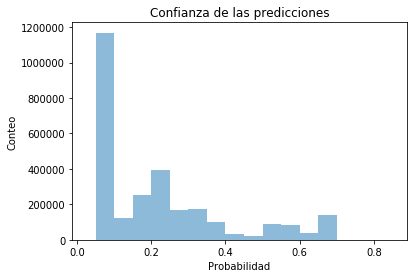

In [21]:
data = [max(x) for x in predict_prob]
# fixed bin size
bins = np.arange(-0, 0.8, 0.05) # fixed bin size

plt.xlim([min(data)-0.1, max(data)+0.1])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Confianza de las predicciones')
plt.xlabel('Probabilidad')
plt.ylabel('Conteo')

plt.show()

In [22]:
clasificacion_predicted2  = clasificacion_predicted
for i in range(len(predict_prob)):
    if max(predict_prob[i]) < 0.1:
        clasificacion_predicted2[i]="Indefinido"

In [23]:
data_to_predict["clasificacion"] = clasificacion_predicted2

C:\Users\jcamp\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
data_to_predict.to_pickle("./transactions_to_predict_classified_StemmingSVM.pkl")

In [25]:
data_classified.to_pickle("./transactions_with_classification_StemmingSVM.pkl")

In [1]:
import pandas as pd
import numpy as np

data_to_predict = pd.read_pickle("./transactions_to_predict_classified_StemmingSVM.pkl")
data_classified = pd.read_pickle("./transactions_with_classification_StemmingSVM.pkl")
df_final = pd.concat([data_to_predict, data_classified], ignore_index=True)
df_final = df_final.drop(['sector', 'subsector','descripcion', 'descripcion2'], axis=1)
df_final.to_pickle("./transactions_classified_ligera_StemmingSVM.pkl")
#df_final.to_csv("./transactions_classified_ligera.csv", encoding = 'utf-8')

Aquellos valores en donde la predicción era menor a 0.1 se les asigno una nueva categoria denominada indefinido y posteriormente se eliminaron estos valores.

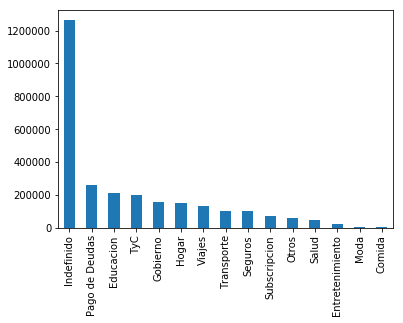

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
data_to_predict.clasificacion.value_counts().plot(kind='bar')

In [3]:
data_to_predict[data_to_predict["clasificacion"]=="Pago de Deudas"].ref.value_counts()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


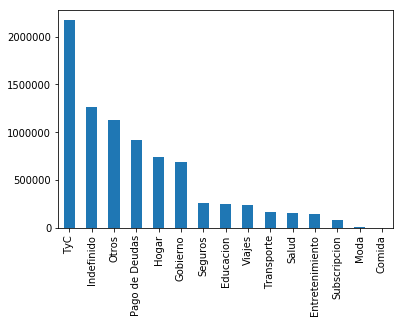

In [4]:
df_final.clasificacion.value_counts().plot(kind='bar')

Se eliminan aquellos valores indefinidos para terminar con 6'983669 datos bien clasificados.

In [6]:
df_final.count() - df_final.loc[df_final["clasificacion"]=="Indefinido"].count()

id_trn_ach       6983666
id_cliente       6983666
fecha            6983666
hora             6983666
valor_trx        6983666
ref              6983669
clasificacion    6983669
dtype: int64

El resultado final se guarda en un archivo csv.

In [5]:
df_final.to_csv("./transactions_classified_ligera_StemmingSVM.csv", encoding = 'utf-8')